In [1]:
import numpy as np
from numpy import pi
from matplotlib.pyplot import *

## Calculate

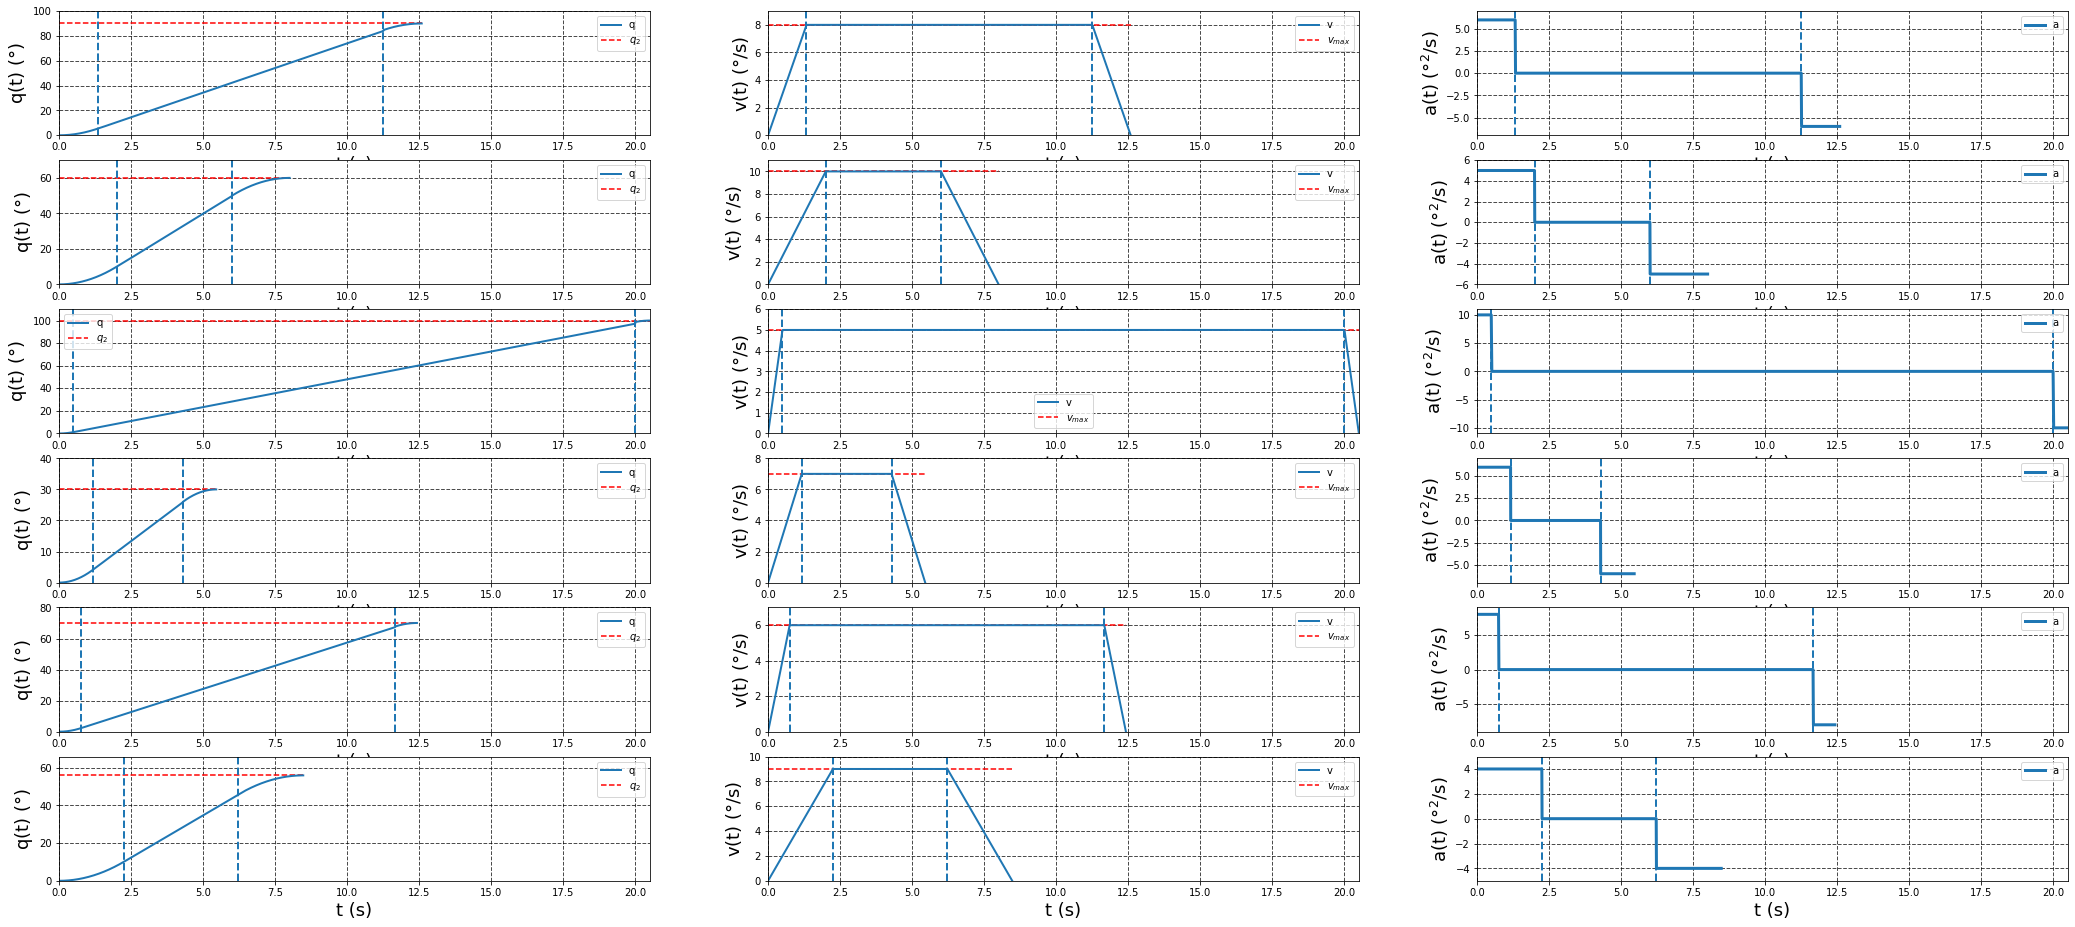

In [9]:
def trajectory_time(params, t0 = 0): 
  q0,qf,dq_m,ddq_m = params

  dq = qf-q0
  #triangular check 
  c = np.sqrt(abs(dq*ddq_m)) 

  if c <= dq_m: 
    t1 = np.sqrt(abs(dq/ddq_m))
    T = t1
    tf = 2*t1
  else: 
    t1 = dq_m/ddq_m
    T = dq/dq_m
    tf = T+t1 
  
  return t0, t1,T,tf 

def plan_trajectory(q_params, t_params):
  t0,t1,T,tf = t_params
  q0,qf,dq_m,ddq_m = q_params 
  t = np.linspace(0,tf, int(1000))
  q = []
  v = []
  a = []

  for i in t: 

    if i <=t1:
      qi = q0 + (0.5*ddq_m*(i-0)**2)
      q02 = qi
      vi = ddq_m*i
      v02 = vi 
      ai = ddq_m
      
    elif i > t1 and i <= T: 
      vi = dq_m
      qi =  q02 + v02*(i-t1)
      ai = 0 
      
    elif i > T: 
      vi = ddq_m*(tf-i)
      qi = qf - (0.5*ddq_m*(i-tf)**2)
      ai = -ddq_m

    q.append(qi)
    v.append(vi) 
    a.append(ai)

  t = np.linspace(t0,t0 + tf, int(1000))

  return t, q, v, a

def plot_joints(joints):

  tf_max = 0
  for i, joint in enumerate(joints):
    j_t = trajectory_time(joint)
    tf_max = max(tf_max, j_t[3])

  figure(figsize=(36,16))
  for i, joint in enumerate(joints):
    #calculate trajectory time for each
    j_t = trajectory_time(joint)
    #calculate each trajectory
    T,q,v,a = plan_trajectory(joint,j_t)
    #extract time params for plotting
    _,t_,T_,tf = j_t

    subplot(len(joints), 3, 3*i + 2)
    plot(T,v, linewidth=2, label="v")
    xlabel('t (s)', fontsize=18)
    ylabel(r'v(t) ($\degree$/s)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([0,tf_max])
    ylim([0,max(v)+1])
    hlines(joint[2], 0,tf, linestyles='--', color='r', label=r"$v_{max}$")
    vlines([t_,T_], 0, max(q), linestyles='--', linewidth=2)
    legend()

    subplot(len(joints), 3, 3*i + 1)
    plot(T,q, linewidth=2, label="q")
    xlabel('t (s)', fontsize=18)
    ylabel(r'q(t) ($\degree$)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([0,tf_max])
    ylim([0,max(q)+10])
    hlines(joint[1], 0,tf, linestyles='--', color='r', label=r"$q_{2}$")
    vlines([t_,T_], 0, max(q)+10, linestyles='--', linewidth=2)
    legend()


    subplot(len(joints), 3, 3*i + 3)
    plot(T,a, linewidth=3, label="a")
    xlabel('t (s)', fontsize=18)
    ylabel(r'a(t) ($\degree^2$/s)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([0,tf_max])
    ylim([min(a)-1,max(a)+1])
    vlines([t_,T_], min(a)-1, max(a)+1, linestyles='--', linewidth=2)
    legend()
  pass

# params [q0,qf,dq_m, ddq_m]
j1 = [0,90,8,6]
j2 = [0,60,10, 5]
j3 = [0,100,5,10]
j4 = [0,30,7,6]
j5 = [0,70,6,8]
j6 = [0,56,9,4]

plot_joints([j1,j2,j3,j4,j5,j6])

show()

## Synchronization

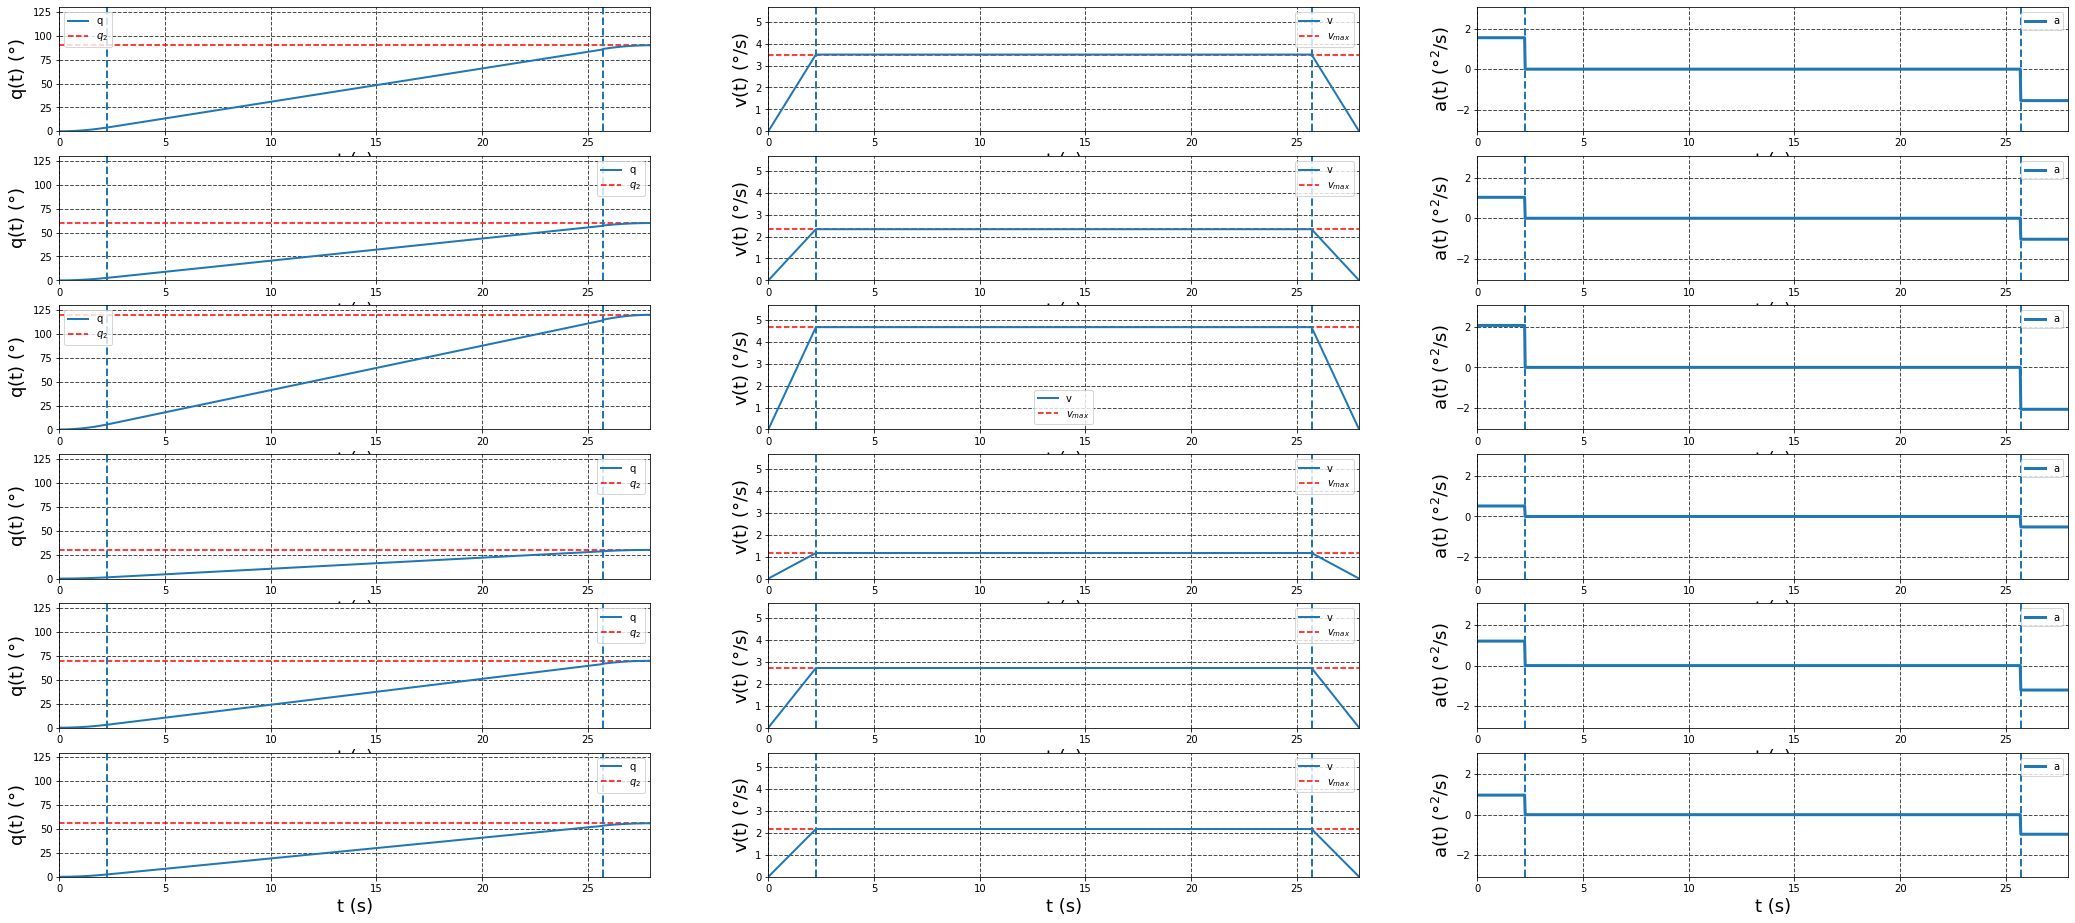

In [3]:
def plot_joints_with_synchronization(joints):
  t0 = 0
  tf_max = 0
  dwell = 0
  t1 = 0
  for joint in joints:
    j_t = trajectory_time(joint)
    tf_max = max(tf_max, j_t[3])
    t1 = max(t1, j_t[1])
    dwell = max(dwell, j_t[2] - j_t[1])

  T = dwell + t1
  tf = T + t1
  t_params = [t0,t1,T, tf]
  
  q_max, v_max, a_max = 0,0,0
  for joint in joints:
    dq_m = (joint[1]-joint[0])/T
    ddq_m = dq_m/t1
    joint[2:] = [dq_m, ddq_m]
    
    _,q,v,a = plan_trajectory(joint,t_params)
    q_max = max(q_max, max(q))
    v_max = max(v_max, max(v))
    a_max = max(a_max, max(a))

  figure(figsize=(36,16))
  for i, joint in enumerate(joints):
    T,q,v,a = plan_trajectory(joint,t_params)
    _,t_,T_,tf = t_params

    subplot(len(joints), 3, 3*i + 2)
    plot(T,v, linewidth=2, label="v")
    xlabel('t (s)', fontsize=18)
    ylabel(r'v(t) ($\degree$/s)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([0,tf])
    ylim([0,v_max+1])
    hlines(joint[2], 0,tf, linestyles='--', color='r', label=r"$v_{max}$")
    vlines([t_,T_], 0, q_max, linestyles='--', linewidth=2)
    legend()

    subplot(len(joints), 3, 3*i + 1)
    plot(T,q, linewidth=2, label="q")
    xlabel('t (s)', fontsize=18)
    ylabel(r'q(t) ($\degree$)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([0,tf])
    ylim([0,q_max+10])
    hlines(joint[1], 0,tf, linestyles='--', color='r', label=r"$q_{2}$")
    vlines([t_,T_], 0, q_max+10, linestyles='--', linewidth=2)
    legend()


    subplot(len(joints), 3, 3*i + 3)
    plot(T,a, linewidth=3, label="a")
    xlabel('t (s)', fontsize=18)
    ylabel(r'a(t) ($\degree^2$/s)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([0,tf])
    ylim([-a_max-1,a_max+1])
    vlines([t_,T_], -a_max-1, a_max+1, linestyles='--', linewidth=2)
    legend()
  pass

# params [q0,qf,dq_m, ddq_m]
j1 = [0,90,8,6]
j2 = [0,60,3,10]
j3 = [0,120,5,9]
j4 = [0,30,7,6]
j5 = [0,70,6,8]
j6 = [0,56,9,4]

plot_joints_with_synchronization([j1,j2,j3,j4,j5,j6])

show()

## Numerical control

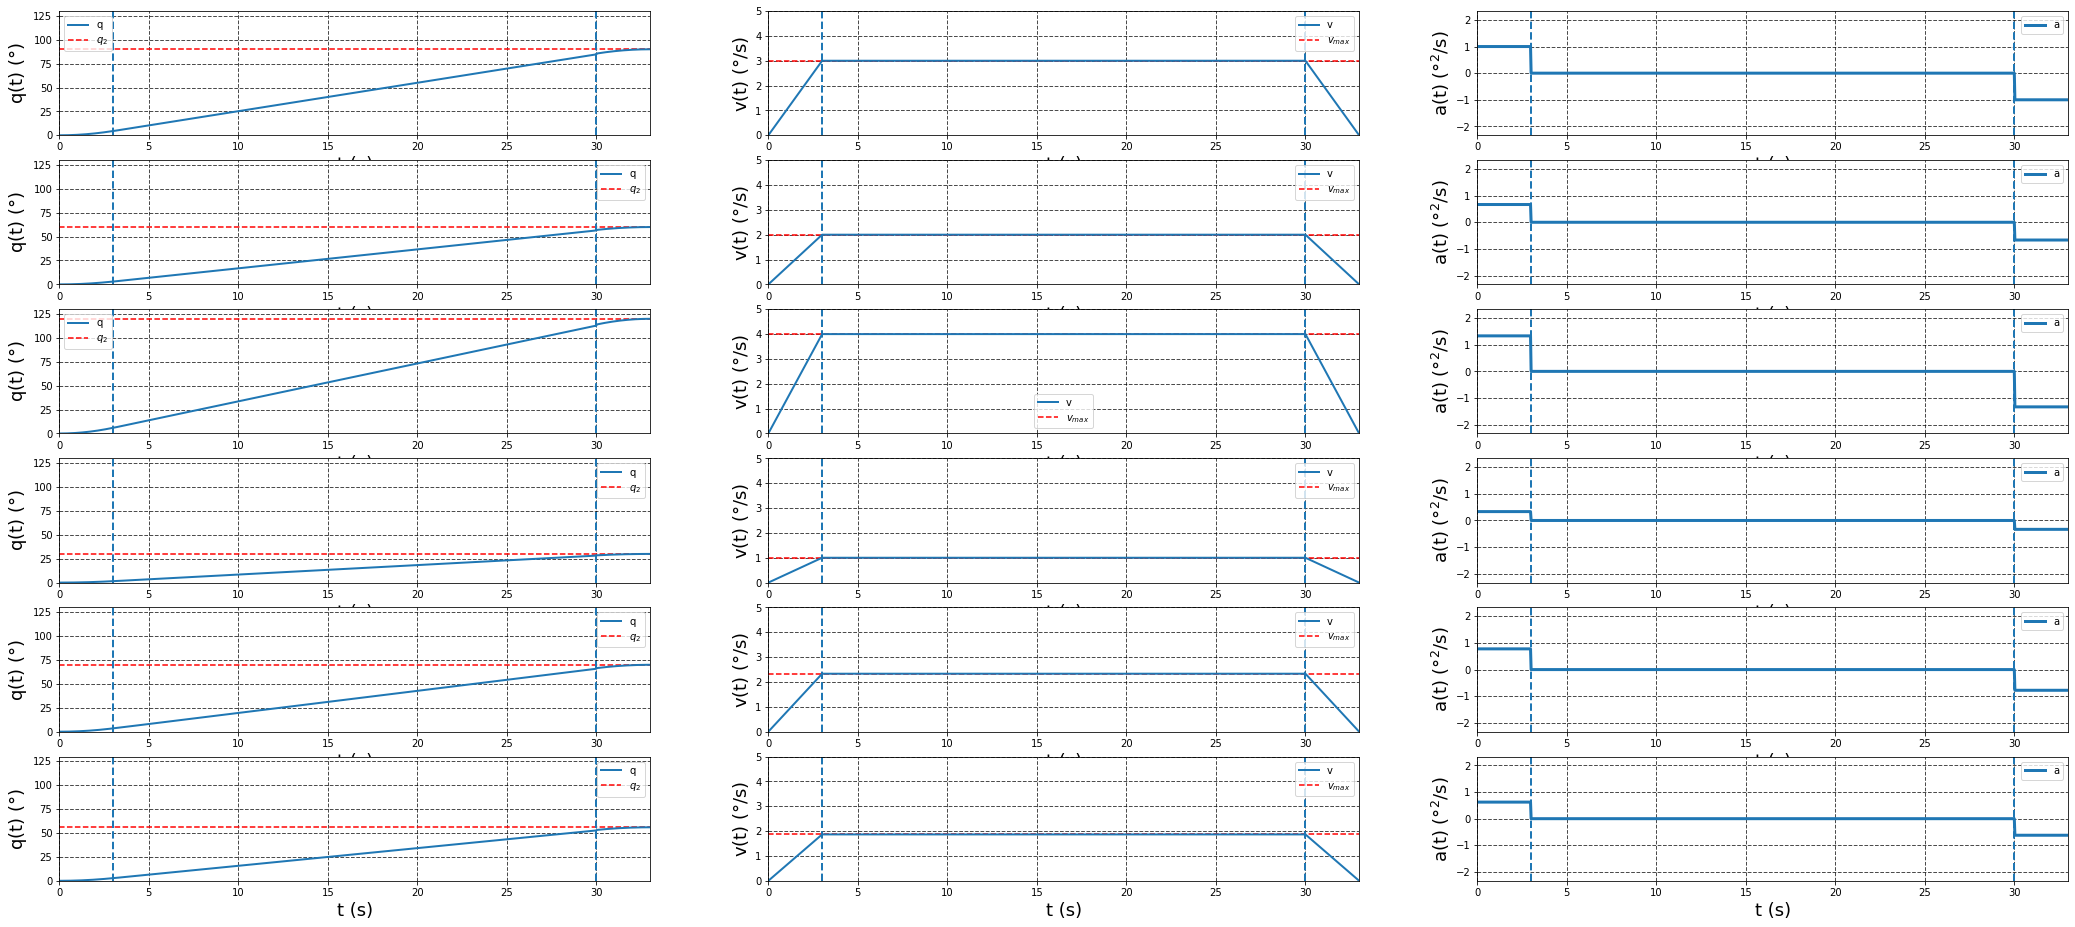

In [5]:
def plot_joints_with_synchronization_and_normal_control(joints, freq = 3, t0=0):
  times = np.array([trajectory_time(joint, t0=t0) for joint in joints])
  t0_max, t1_max, T_max, tf_max = times.max(0)
  dwell = (times[:,2] - times[:,1]).max()
  T_max = t1_max + dwell
  
  #new times for normal control
  t1_modified = np.ceil(t1_max/freq) * freq
  T_modified = (np.ceil(T_max/freq) + 1) * freq
  tf_modified = t1_modified + T_modified
  t_params = [t0_max,t1_modified,T_modified, tf_modified]
  
  for joint in joints:
    dq_m = (joint[1]-joint[0])/T_modified
    ddq_m = dq_m/t1_modified
    joint[2:] = [dq_m, ddq_m]
  
  trajectories = [plan_trajectory(joint,t_params) for joint in joints]
  q_max = np.max([max(traj[1]) for traj in trajectories])
  v_max = np.max([max(traj[2]) for traj in trajectories])
  a_max = np.max([max(traj[3]) for traj in trajectories])

  figure(figsize=(36,16))
  for i, joint in enumerate(joints):
    T,q,v,a = plan_trajectory(joint,t_params)
    _,t_,T_,tf = t_params

    subplot(len(joints), 3, 3*i + 2)
    plot(T,v, linewidth=2, label="v")
    xlabel('t (s)', fontsize=18)
    ylabel(r'v(t) ($\degree$/s)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([t0,t0 + tf])
    ylim([0,v_max+1])
    hlines(joint[2], t0,t0 + tf, linestyles='--', color='r', label=r"$v_{max}$")
    vlines([t_,T_], 0, q_max, linestyles='--', linewidth=2)
    legend()

    subplot(len(joints), 3, 3*i + 1)
    plot(T,q, linewidth=2, label="q")
    xlabel('t (s)', fontsize=18)
    ylabel(r'q(t) ($\degree$)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([t0,t0 + tf])
    ylim([0,q_max+10])
    hlines(joint[1], t0,t0 + tf, linestyles='--', color='r', label=r"$q_{2}$")
    vlines([t_,T_], 0, q_max+10, linestyles='--', linewidth=2)
    legend()


    subplot(len(joints), 3, 3*i + 3)
    plot(T,a, linewidth=3, label="a")
    xlabel('t (s)', fontsize=18)
    ylabel(r'a(t) ($\degree^2$/s)', fontsize=18)
    grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
    grid(True)
    xlim([t0,t0 + tf])
    ylim([-a_max-1,a_max+1])
    vlines([t_,T_], -a_max-1, a_max+1, linestyles='--', linewidth=2)
    legend()
  return T_modified

# params [q0,qf,dq_m, ddq_m]
j1 = [0,90,8,6]
j2 = [0,60,3,10]
j3 = [0,120,5,9]
j4 = [0,30,7,6]
j5 = [0,70,6,8]
j6 = [0,56,9,4]

plot_joints_with_synchronization_and_normal_control([j1,j2,j3,j4,j5,j6])

show()

## Trajectory junction

In [6]:
# def plot_joints_with_synchronization_and_normal_control_and_trajectory_junction(joints, freq = 3, t0=0):
#   times = np.array([trajectory_time(joint, t0=t0) for joint in joints])
#   t0_max, t1_max, T_max, tf_max = times.max(0)
#   dwell = (times[:,2] - times[:,1]).max()
#   T_max = t1_max + dwell
  
#   #new times for normal control
#   t1_modified = np.ceil(t1_max/freq) * freq
#   T_modified = (np.ceil(T_max/freq) + 1) * freq
#   tf_modified = t1_modified - t0_max + T_modified
#   t_params = [t0_max,t1_modified,T_modified, tf_modified]
  
#   for joint in joints:
#     dq_m = (joint[1]-joint[0])/T_modified
#     ddq_m = dq_m/t1_modified
#     joint[2:] = [dq_m, ddq_m]
  
#   trajectories = [plan_trajectory(joint,t_params) for joint in joints]
#   q_max = np.max([max(traj[1]) for traj in trajectories])
#   v_max = np.max([max(traj[2]) for traj in trajectories])
#   a_max = np.max([max(traj[3]) for traj in trajectories])

#   figure(figsize=(36,16))
#   for i, joint in enumerate(joints):
#     T,q,v,a = plan_trajectory(joint,t_params)
#     _,t_,T_,tf = t_params

#     subplot(len(joints), 3, 3*i + 2)
#     plot(T,v, linewidth=2, label="v")
#     xlabel('t (s)', fontsize=18)
#     ylabel(r'v(t) ($\degree$/s)', fontsize=18)
#     grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
#     grid(True)
#     xlim([0,tf])
#     ylim([0,v_max+1])
#     hlines(joint[2], 0,tf, linestyles='--', color='r', label=r"$v_{max}$")
#     vlines([t_,T_], 0, q_max, linestyles='--', linewidth=2)
#     legend()

#     subplot(len(joints), 3, 3*i + 1)
#     plot(T,q, linewidth=2, label="q")
#     xlabel('t (s)', fontsize=18)
#     ylabel(r'q(t) ($\degree$)', fontsize=18)
#     grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
#     grid(True)
#     xlim([0,tf])
#     ylim([0,q_max+10])
#     hlines(joint[1], 0,tf, linestyles='--', color='r', label=r"$q_{2}$")
#     vlines([t_,T_], 0, q_max+10, linestyles='--', linewidth=2)
#     legend()


#     subplot(len(joints), 3, 3*i + 3)
#     plot(T,a, linewidth=3, label="a")
#     xlabel('t (s)', fontsize=18)
#     ylabel(r'a(t) ($\degree^2$/s)', fontsize=18)
#     grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
#     grid(True)
#     xlim([0,tf])
#     ylim([-a_max-1,a_max+1])
#     vlines([t_,T_], -a_max-1, a_max+1, linestyles='--', linewidth=2)
#     legend()

# # params [q0,qf,dq_m, ddq_m]
# j1 = [[0,90, 60, 100],8,6]
# j2 = [[0,60, 30, 80],3,10]
# j3 = [[0,100, 120, 90],5,9]
# j4 = [[0,30, 60, 90],7,6]
# j5 = [[0,70, 50, 40],6,8]
# j6 = [[0,56, 50, 70],9,4]

# plot_joints_with_synchronization_and_normal_control_and_trajectory_junction([j1,j2,j3,j4,j5,j6])

# show()

In [10]:
# params [q0,qf,dq_m, ddq_m]
j1 = [[0,90, 60, 100],8,6]
j2 = [[0,60, 30, 80],3,10]
j3 = [[0,100, 120, 90],5,9]
j4 = [[0,30, 60, 90],7,6]
j5 = [[0,70, 50, 40],6,8]
j6 = [[0,56, 50, 70],9,4]

def plot_joints_with_synchronization_and_normal_control_and_trajectory_junction(joints):
    shift = 0
    for i in range(1, len(j1[0])):
        new_joints = []
        for joint in joints:    
            new_joint = [joint[0][i-1], joint[0][i], joint[1], joint[2]]
            new_joints.append(new_joint)
        dT = plot_joints_with_synchronization_and_normal_control(new_joints, t0=shift)
        shift += dT
    show() 

In [ ]:
plot_joints_with_synchronization_and_normal_control_and_trajectory_junction([j1,j2,j3,j4,j5,j6])

In [1]:
class Point:
    def __init__(self, t,q,v):
        self.t = t
        self.q = q
        self.v = v
    
    def get_point_to_point_plot_line(point1, point2):
        if point1.t == point2.t:
            return [], [], [], []
        num_ticks = 1000
        t = np.linspace(point1.t, point2.t, num_ticks)
        a = (point2.v - point1.v)/(point2.t - point1.t)
        b = (point1.v*point2.t - point2.v*point1.t)/(point2.t - point1.t)

        q = point1.q + 0.5 * a * t**2 + b * t - (0.5 * a * point1.t**2 + b * point1.t)
        v = a * t + b
        a = np.full(num_ticks, a)

        return t, q, v, a

In [2]:
import numpy as np
from matplotlib import pyplot as plt
FREQ = 3


class Joint:
    def __init__(self, positions, dq_max, ddq_max, trajectory_junction_ratio=0, do_normal_control=False):
        self.positions = positions
        self.dq_max = dq_max
        self.ddq_max = ddq_max
        self.trajectory_junction_ratio = trajectory_junction_ratio
        # Format of one trajectory: [t0, t1, T, tf]
        self.trajectories = []
        self.calculate_path(trajectory_junction_ratio, t0=0)
        if do_normal_control:
            self.normal_control()

    def calculate_trajectory(q0, qf, dq_m, ddq_m, t0):
        dq = abs(qf-q0)
        # triangular check
        c = np.sqrt(dq*ddq_m)

        if c <= dq_m:
            t1 = np.sqrt(dq/ddq_m)
            T = t1
            tf = 2*t1
        else:
            t1 = dq_m/ddq_m
            T = dq/dq_m
            tf = T+t1

        dq_m *= np.sign(qf-q0)
        ddq_m *= np.sign(qf-q0)

        t0_point = Point(t0, q0, 0)
        t1_point = Point(t0 + t1, q0 + (0.5*ddq_m*t1**2),
                         dq_m)
        T_point = Point(t0 + T, q0 + (0.5*ddq_m*t1**2) +
                        dq_m*(T-t1), dq_m)
        tf_point = Point(t0 + tf, qf, 0)
        return t0_point, t1_point, T_point, tf_point

    def calculate_path(self, t0=0):
        self.trajectories = []
        for i in range(1, len(self.positions)):
            t0_point, t1_point, T_point, tf_point = Joint.calculate_trajectory(
                self.positions[i-1], self.positions[i], self.dq_max, self.ddq_max, t0)
            self.trajectories.append([t0_point, t1_point, T_point, tf_point])
            t0 = T_point.t + (1-self.trajectory_junction_ratio) * \
                (tf_point.t - T_point.t)

    def normal_control(self):
        points = [point for trajectory in self.trajectories for point in trajectory]

        # Recalculate times
        prev_time, prev_time_modified = 0, 0
        for point in points:
            t_modified = prev_time_modified + \
                np.ceil((point.t - prev_time)/FREQ) * FREQ
            prev_time = point.t
            point.t = t_modified
            prev_time_modified = t_modified

        # Recalculate velocities
        for i in range(len(self.trajectories)):
            trajectory = self.trajectories[i]
            new_v = (self.positions[i+1] - self.positions[i]
                     )/(trajectory[2].t - trajectory[0].t)
            trajectory[1].v = new_v
            trajectory[2].v = new_v

        # Recalculate positions
        for trajectory in self.trajectories:
            ddq_m = (trajectory[1].v - trajectory[0].v) / \
                (trajectory[1].t - trajectory[0].t)
            trajectory[1].q = trajectory[0].q + \
                (0.5*ddq_m*(trajectory[1].t - trajectory[0].t)**2)
            trajectory[2].q = trajectory[1].q + trajectory[1].v * \
                (trajectory[2].t - trajectory[1].t)

    def get_path_points(self):
        points = [point for trajectory in self.trajectories for point in trajectory]
        if self.trajectory_junction_ratio == 0:
            return points

        path_points = [points[0]]
        for i in range(len(points)):
            if i % 4 == 1 or i % 4 == 2:
                path_points.append(points[i])
        path_points.append(points[-1])

        return path_points

    def plot_path_points(self, points):
        points = self.get_path_points()
        plt.figure(figsize=(18, 8))

        T, Q, V, A = [], [], [], []
        for i in range(1, len(points)):
            t, q, v, a = Point.get_point_to_point_plot_line(
                points[i-1], points[i])
            T = np.concatenate((T, t))
            Q = np.concatenate((Q, q))
            V = np.concatenate((V, v))
            A = np.concatenate((A, a))

        plt.subplot(1, 3, 1)
        plt.plot(T, Q, linewidth=2, label="q", c='b')
        plt.grid(True)

        plt.subplot(1, 3, 2)
        plt.plot(T, V, linewidth=2, label="v", c='b')
        plt.grid(True)
        # plt.hlines(joint[2], 0,tf, linestyles='--', color='r', label=r"$v_{max}$")
        # plt.vlines([T[0]], 0, 8, linestyles='--', linewidth=2)

        plt.subplot(1, 3, 3)
        plt.plot(T, A, linewidth=2, label="a", c='b')
        plt.grid(True)

        plt.show() 

In [ ]:
#     subplot(len(joints), 3, 3*i + 2)
#     plot(T,v, linewidth=2, label="v")
#     xlabel('t (s)', fontsize=18)
#     ylabel(r'v(t) ($\degree$/s)', fontsize=18)
#     grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
#     grid(True)
#     xlim([0,tf])
#     ylim([0,v_max+1])
#     hlines(joint[2], 0,tf, linestyles='--', color='r', label=r"$v_{max}$")
#     vlines([t_,T_], 0, q_max, linestyles='--', linewidth=2)
#     legend()

In [ ]:


        plt.figure(figsize=(18, 8))

        T, Q, V, A = [], [], [], []
        for i in range(1, len(point_path)):
            t, q, v, a = Point.get_point_to_point_plot_line(
                point_path[i-1], point_path[i])
            T = np.concatenate((T, t))
            Q = np.concatenate((Q, q))
            V = np.concatenate((V, v))
            A = np.concatenate((A, a))

        plt.subplot(1, 3, 1)
        plt.plot(T, Q, linewidth=2, label="q", c='b')
        plt.grid(True)

        plt.subplot(1, 3, 2)
        plt.plot(T, V, linewidth=2, label="v")
        plt.grid(True)
        # plt.hlines(joint[2], 0,tf, linestyles='--', color='r', label=r"$v_{max}$")
        # plt.vlines([T[0]], 0, 8, linestyles='--', linewidth=2)

        plt.subplot(1, 3, 3)
        plt.plot(T, A, linewidth=2, label="a", c='b')
        plt.grid(True)

        plt.show()

    def plot_trajectories(self):
        points = [point for trajectory in self.trajectories for point in trajectory]

        plt.figure(figsize=(18, 8))

        for trajectory in self.trajectories:
            T, Q, V, A = [], [], [], []
            for i in range(1, len(trajectory)):
                t, q, v, a = Point.get_point_to_point_plot_line(
                    trajectory[i-1], trajectory[i])
                T = np.concatenate((T, t))
                Q = np.concatenate((Q, q))
                V = np.concatenate((V, v))
                A = np.concatenate((A, a))

            plt.subplot(1, 3, 1)
            plt.plot(T, Q, linewidth=2, label="q", c='b')
            plt.grid(True)

            plt.subplot(1, 3, 2)
            plt.plot(T, V, linewidth=2, label="v")
            plt.grid(True)
            # plt.hlines(joint[2], 0,tf, linestyles='--', color='r', label=r"$v_{max}$")
            # plt.vlines([T[0]], 0, 8, linestyles='--', linewidth=2)

            plt.subplot(1, 3, 3)
            plt.plot(T, A, linewidth=2, label="a", c='b')
            plt.grid(True)

        plt.show()


In [8]:
j1 = Joint([0, 90, 60, 100], dq_max=8, ddq_max=6)
# j2 = Joint([0, 60, 30, 80], 3, 10)
j3 = Joint([0, 100, 120, 90], 5, 9)
# j4 = Joint([0, 30, 60, 90], 7, 6)
# j5 = Joint([0, 70, 50, 40], 6, 8)
# j6 = Joint([0, 56, 50, 70], 9, 4)

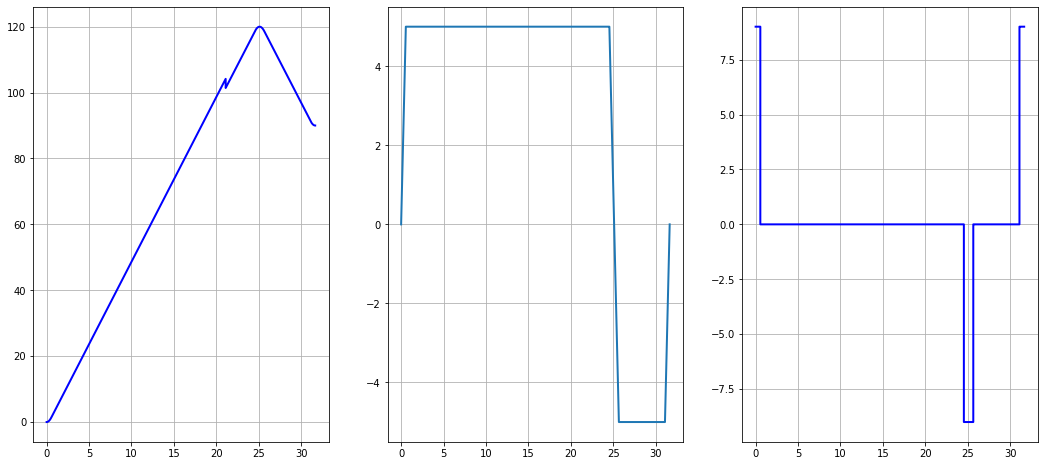

In [10]:
j3.plot_path(junction=True)

In [19]:
# for traj in j1.trajectories:
#     for point in traj:
#         print("t:", point.t)
#         print("q:", point.q)
#         print("v:", point.v)
#         print()
#     print("End of trajectory")
#     print("--------------------------")


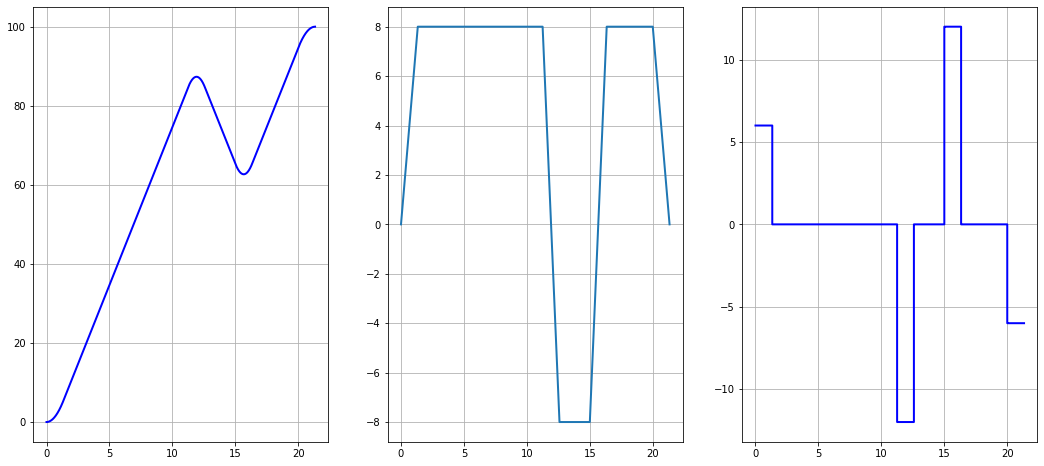

In [4]:
j1.plot_path(junction=True)

In [21]:
j1.normal_control_path()

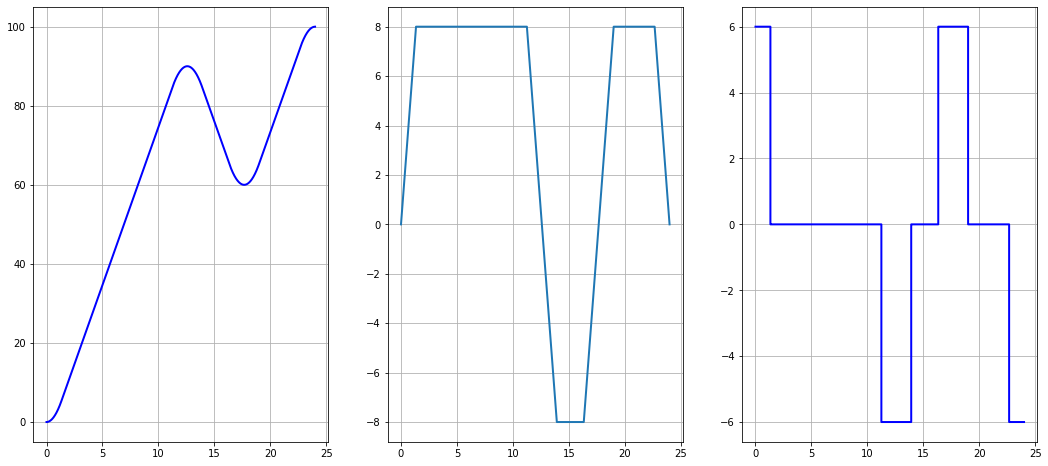

In [7]:
j1.plot_path()

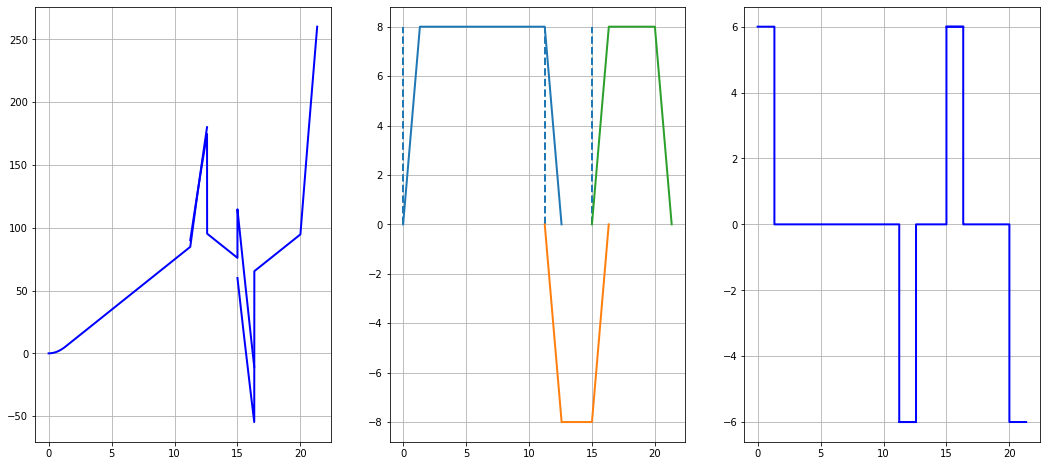

In [13]:
j1.plot_trajectories()

In [ ]:
#     subplot(len(joints), 3, 3*i + 2)
#     plot(T,v, linewidth=2, label="v")
#     xlabel('t (s)', fontsize=18)
#     ylabel(r'v(t) ($\degree$/s)', fontsize=18)
#     grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
#     grid(True)
#     xlim([0,tf])
#     ylim([0,v_max+1])
#     hlines(joint[2], 0,tf, linestyles='--', color='r', label=r"$v_{max}$")
#     vlines([t_,T_], 0, q_max, linestyles='--', linewidth=2)
#     legend()

In [ ]:
  times = np.array([trajectory_time(joint, t0=t0) for joint in joints])
  t0_max, t1_max, T_max, tf_max = times.max(0)
  dwell = (times[:,2] - times[:,1]).max()
  T_max = t1_max + dwell
  
  #new times for normal control
  t1_modified = np.ceil(t1_max/freq) * freq
  T_modified = (np.ceil(T_max/freq) + 1) * freq
  tf_modified = t1_modified + T_modified
  t_params = [t0_max,t1_modified,T_modified, tf_modified]
  
  for joint in joints:
    dq_m = (joint[1]-joint[0])/T_modified
    ddq_m = dq_m/t1_modified
    joint[2:] = [dq_m, ddq_m]
  
  trajectories = [plan_trajectory(joint,t_params) for joint in joints]
  q_max = np.max([max(traj[1]) for traj in trajectories])
  v_max = np.max([max(traj[2]) for traj in trajectories])
  a_max = np.max([max(traj[3]) for traj in trajectories])

In [ ]:
# import numpy as np
# from matplotlib import pyplot as plt
# FREQ = 3

# class Joint:
#     def __init__(self, positions, dq_max, ddq_max):
#         self.positions = positions
#         self.dq_max = dq_max
#         self.ddq_max = ddq_max
#         # Format of one trajectory: [t0, t1, T, tf]
#         self.trajectories = []
#         self.calculate_path(self.positions, t0=0)

#     def calculate_trajectory(q0, qf, dq_m, ddq_m, t0):
#         dq = abs(qf-q0)
#         # triangular check
#         c = np.sqrt(dq*ddq_m)

#         if c <= dq_m:
#             t1 = np.sqrt(dq/ddq_m)
#             T = t1
#             tf = 2*t1
#         else:
#             t1 = dq_m/ddq_m
#             T = dq/dq_m
#             tf = T+t1

#         t0_point = Point(t0, q0, 0)
#         t1_point = Point(t0 + t1, q0 + (0.5*ddq_m*t1**2), dq_m)
#         T_point = Point(t0 + T, q0 + (0.5*ddq_m*t1**2) + dq_m*(T-t1), dq_m)
#         tf_point = Point(t0 + tf, qf, 0)
#         return t0_point, t1_point, T_point, tf_point

#     def calculate_path(self, t0=0):
#         self.trajectories = []
#         for i in range(1, len(self.positions)):
#             t0_point, t1_point, T_point, tf_point = Joint.calculate_trajectory(
#                 self.positions[i-1], self.positions[i], self.dq_max, self.ddq_max, t0)
#             self.trajectories.append([t0_point, t1_point, T_point, tf_point])
#             t0 = T_point.t
    
#     def normal_control_path(self):
#         for trajectory in self.trajectories:
#             t0_point, t1_point, T_point, tf_point = trajectory
#             t0_modified = np.ceil(t0_point.t/FREQ) * FREQ
#             t1_modified = np.ceil(t1_max/FREQ) * FREQ
#             Joint.calculate_trajectory(
#             t1_modified = np.ceil(t1_max/FREQ) * FREQ
#             T_modified = (np.ceil(T_max/FREQ) + 1) * FREQ
#             tf_modified = t1_modified + T_modified
#             t_params = [t0_max,t1_modified,T_modified, tf_modified]
        
#         for joint in joints:
#             dq_m = (joint[1]-joint[0])/T_modified
#             ddq_m = dq_m/t1_modified
#             joint[2:] = [dq_m, ddq_m]

#     def get_trajectory(self, q0, qf, trajectory_times):
#         t0, t1, T, tf = trajectory_times
#         t1, T, tf = t1 - t0, T - t0, tf - t0
#         t = np.linspace(0, tf, int(1000))
#         q = []
#         v = []
#         a = []

#         for i in t:

#             if i <= t1:
#                 qi = q0 + (0.5*self.ddq_max*i**2)
#                 vi = self.ddq_max*i
#                 ai = self.ddq_max

#             elif i > t1 and i <= T:
#                 qi = q0 + (0.5*self.ddq_max*t1**2) + self.dq_max*(i-t1)
#                 vi = self.dq_max
#                 ai = 0

#             elif i > T:
#                 qi = qf - (0.5*self.ddq_max*(i-tf)**2)
#                 vi = self.ddq_max*(tf-i)
#                 ai = -self.ddq_max

#             q.append(qi)
#             v.append(vi)
#             a.append(ai)

#         return t + t0, q, v, a
